In [1]:
!pip install tabulate


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


1. Data Preprocessing

In [1]:
import  re, string
import pandas as pd
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

df = pd.read_csv("bbc-text.csv")

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    text = re.findall(r"[a-z]+", text)
    tokens = [word for word in tokens if word not in stop_words ]
    return tokens

df['tokens'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mary_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from tabulate import tabulate

In [6]:
table = tabulate(df[["category", "tokens"]].head(10),
                 headers="keys",
                 tablefmt="grid",
                 showindex=True)


2. Implement Bag of Words

In [9]:
def build_vocab(token_lists, min_freq = 1):
    vocab = {}
    word_freq = {}
    for tokens in token_lists:
        for token in tokens:
            word_freq[token] = word_freq.get(token, 0) + 1
    idx = 0
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

vocab = build_vocab(df['tokens'])
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 32955


In [7]:
import numpy as np

In [10]:
def doc_to_bow(tokens, vocab):
    vec = np.zeros(len(vocab))
    for token in tokens:
        if token in vocab:
            vec[vocab[token]] += 1
    return vec

df['bow_vector'] = df['tokens'].apply(lambda x: doc_to_bow(x, vocab))
print("BoW vector example:")
print(df['bow_vector'].iloc[0][:20])

BoW vector example:
[12.  2.  2.  3.  2.  1.  1.  1.  4.  2.  2.  2.  2.  1.  1.  1.  2.  7.
  4.  1.]


3. Implement TF-IDF

In [11]:
def compute_tf(tokens, vocab):
    tf_vec = np.zeros(len(vocab))
    total_terms = len(tokens)
    for token in tokens:
        if token in vocab:
            tf_vec[vocab[token]] += 1
    tf_vec = tf_vec / total_terms

    return tf_vec

df['tf_vector'] = df['tokens'].apply(lambda x: compute_tf(x, vocab))

In [12]:
def compute_idf(token_lists, vocab):
    N = len(token_lists)
    idf_vec = np.zeros(len(vocab))
    for word, idx in vocab.items():
        df_t = sum(1 for tokens in token_lists if word in tokens)
        idf_vec[idx] = np.log((N + 1) / (df_t + 1)) + 1

    return idf_vec

idf_vector = compute_idf(df['tokens'], vocab)


In [13]:
def compute_tfidf(tf_vec, idf_vec):
    return tf_vec * idf_vec

df['tfidf_vector'] = df['tf_vector'].apply(lambda x: compute_tfidf(x, idf_vector))


4. Analysis

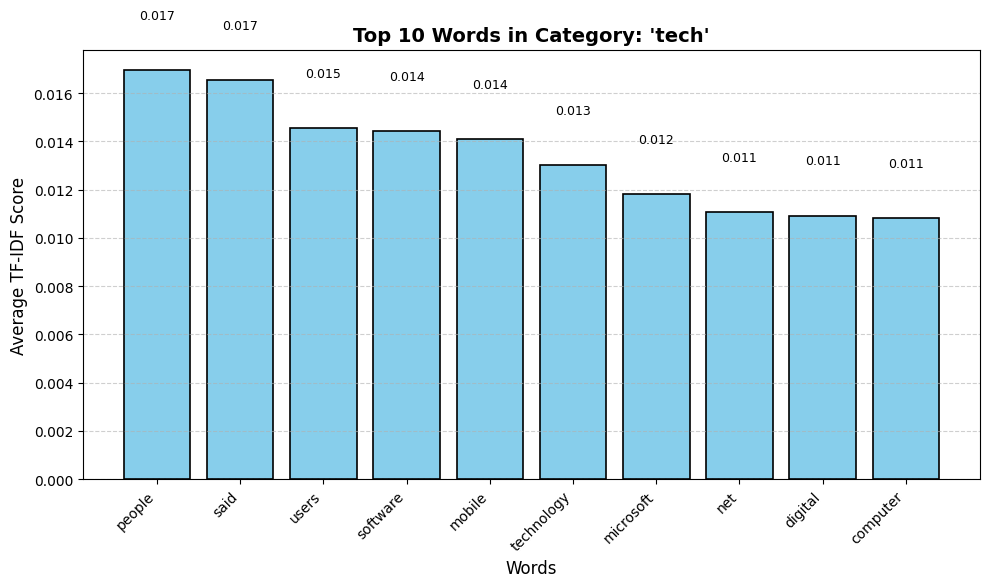

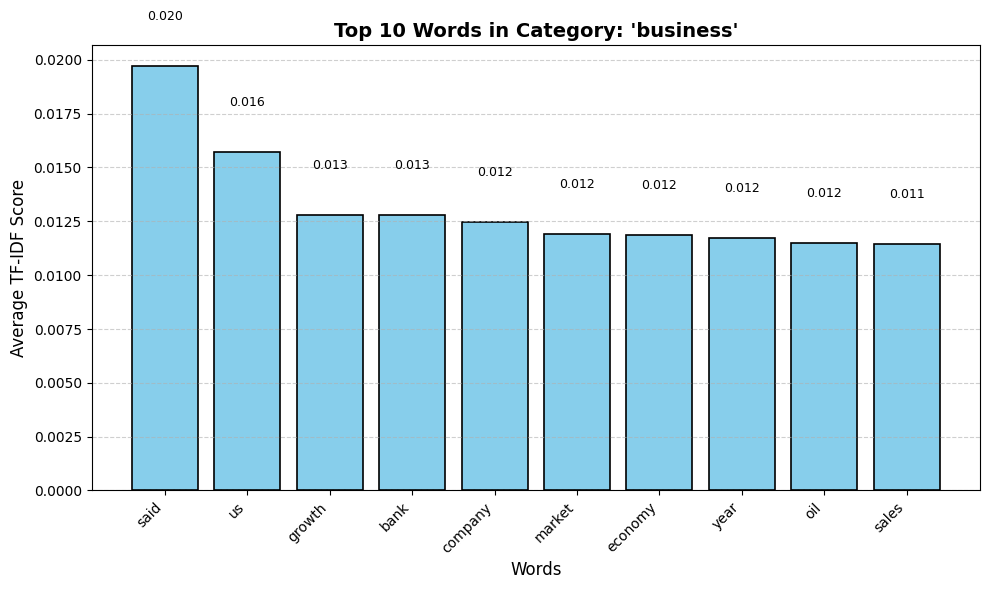

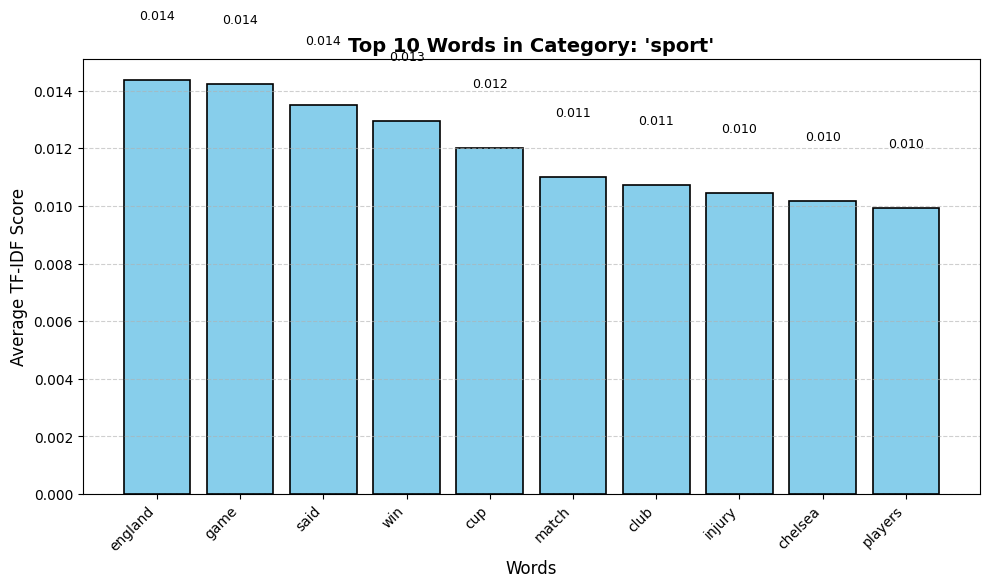

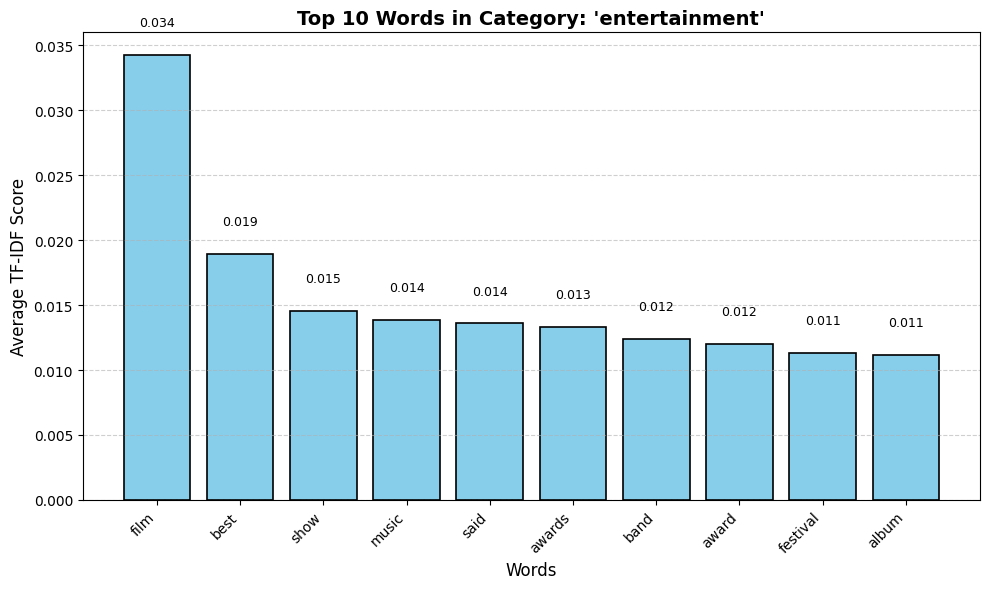

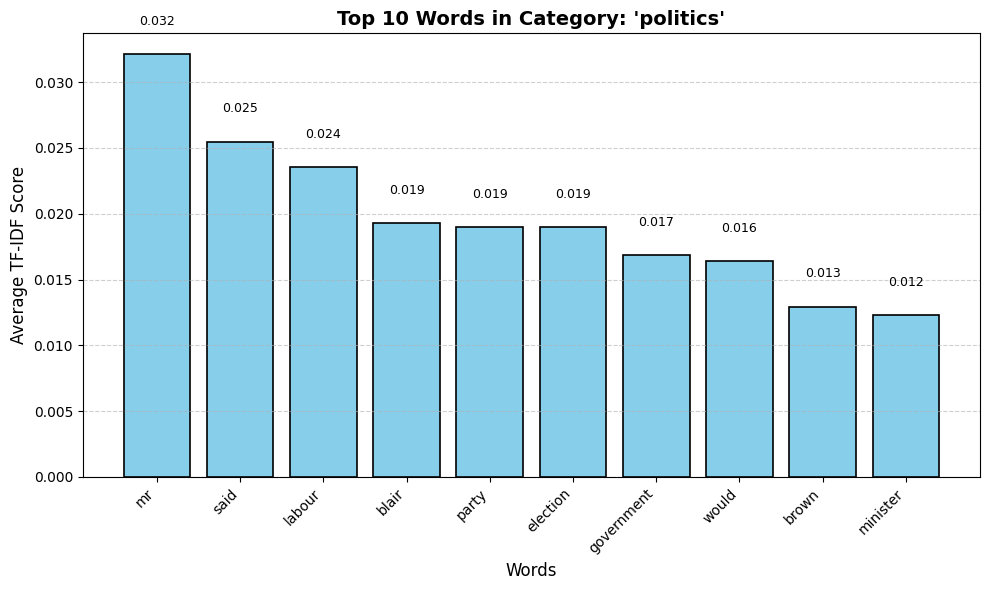

In [14]:
import matplotlib.pyplot as plt

categories = df['category'].unique()

for cat in categories:
    cat_vectors = df[df['category'] == cat]['tfidf_vector']

    avg_tfidf = [
        sum(vec[i] for vec in cat_vectors) / len(cat_vectors)
        for i in range(len(vocab))
    ]

    top_idx = sorted(range(len(avg_tfidf)), key=lambda i: avg_tfidf[i], reverse=True)[:10]

    index_to_word = {idx: word for word, idx in vocab.items()}
    top_words = [index_to_word[i] for i in top_idx]
    top_values = [avg_tfidf[i] for i in top_idx]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(top_words, top_values, color='skyblue', edgecolor='black', linewidth=1.2)

    plt.title(f"Top 10 Words in Category: '{cat}'", fontsize=14, fontweight='bold')
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Average TF-IDF Score", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002, f"{height:.3f}",
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()


In [15]:
high_tf_low_idf = []
low_tf_high_idf = []

threshold_tf = 0.008
threshold_idf = np.median(idf_vector)

for word, idx in vocab.items():
    avg_tf = np.mean([vec[idx] for vec in df['tf_vector']])
    idf_val = idf_vector[idx]

    if avg_tf > threshold_tf and idf_val < threshold_idf:
        high_tf_low_idf.append(word)
    elif avg_tf < threshold_tf and idf_val > threshold_idf:
        low_tf_high_idf.append(word)

print("High TF, Low IDF words:", high_tf_low_idf[:10])
print("Low TF, High IDF words:", low_tf_high_idf[:10])


High TF, Low IDF words: ['said']
Low TF, High IDF words: ['pastimes', 'talkedabout', 'alacarte', 'hume', 'hanlon', 'starcom', 'mediavest', 'stacey', 'jolna', 'scheduler']
